In [1]:
from Network import Generator, Discriminator
import Utils_model, Utils
from Utils_model import VGG_LOSS
from keras.applications.vgg19 import VGG19

import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Add
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization

from skimage import data, io
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np

Using TensorFlow backend.


In [2]:
# how many times the original image is scaled down
downscale_factor = 4
# expected output size
output_image_shape = (1920,1080,3)

input_image_shape = (int(output_image_shape[0]//downscale_factor), int(output_image_shape[1]//downscale_factor), output_image_shape[2])

## Res block

In [3]:
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = Add()([gen, model])
    
    return model

## Upsampling block

In [4]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

## Loss function

In [5]:
class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
    
        return K.mean(K.square(model(y_true) - model(y_pred)))

## Generator

In [6]:
def generator(input_shape):
        
    gen_input = Input(shape = input_image_shape)

    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
    model = PReLU(shared_axes=[1,2])(model)

    gen_model = model

    for index in range(16):
        model = res_block_gen(model, 3, 64, 1)

    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = Add()([gen_model, model])

    for index in range(2):
        model = up_sampling_block(model, 3, 256, 2)

    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
    model = Activation('tanh')(model)

    generator_model = Model(inputs = gen_input, outputs = model)

    return generator_model

## Data

In [7]:
input_dir = '../images/photo_fullhd'
number_of_images = 100
train_test_ratio = 0.8

epochs = 5
batch_count = 101
batch_size = 1

In [8]:
x_train_lr, x_train_hr, x_test_lr, x_test_hr = Utils.load_training_data(input_dir, '.jpg', number_of_images, train_test_ratio, downscale_factor, prog_func=tqdm) 

Converting to low-res: 100%|██████████| 20/20 [00:00<00:00, 39.57it/s]


## Model

In [9]:
generator = generator(input_image_shape)

W0920 03:05:21.125982 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 03:05:21.154270 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 03:05:21.158854 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 03:05:21.229651 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:17

In [10]:
vgg_loss = VGG_LOSS(output_image_shape).vgg_loss

In [11]:
input_layer = Input(shape=input_image_shape)
upscaled_layer = generator(input_layer)

upscale_model = Model(inputs=input_layer, outputs=upscaled_layer)
upscale_model.compile(loss=vgg_loss, optimizer=Adam())

W0920 03:05:29.011891 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0920 03:05:29.043856 139987818297152 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [31]:
for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for b in range(batch_count):

        rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
        #rand_nums = [2]

        image_batch_hr = x_train_hr[rand_nums]
        image_batch_lr = x_train_lr[rand_nums]
        loss = upscale_model.train_on_batch(image_batch_lr, image_batch_hr)
        
        if(b % 10 == 0):
            print ('Batch: %d' % b, ', Loss %f' % loss)

--------------- Epoch 1 ---------------
Batch: 0 , Loss 0.058537
Batch: 10 , Loss 0.027194
Batch: 20 , Loss 0.020824
Batch: 30 , Loss 0.022663
Batch: 40 , Loss 0.052669
Batch: 50 , Loss 0.029325


KeyboardInterrupt: 

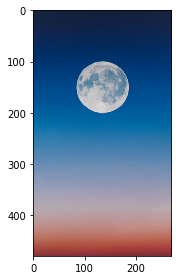

In [18]:
ex = x_train_lr[3]
ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

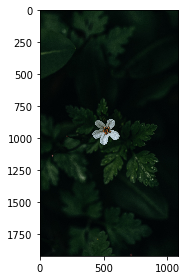

In [14]:
ex = x_train_hr[2]
ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

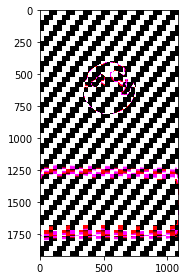

In [33]:
ex = upscale_model.predict(x_train_lr[3:4])[0]
ex = (ex + 1)/2

io.imshow(ex)